# 16.413 Final Project: Convex Risk Bounded Continuous-Time Trajectory Planning for a Europa Lander

Julia Briden (jbriden@mit.edu)
Kota Kondo (kkondo@mit.edu)
Lakshay Sharma (lakshays@mit.edu)
Nick Rober (nrober@mit.edu)
Youngjae Min (youngj0@mit.edu)

## 1. Problem Statement

The year is 2048 and alien life has been detected under the ice of Europa! In the interest of getting to know our newly discovered neighbors, NASA has decided to dispatch a highly specialized fleet of vehicles to the Gallilean moon. The mission will consist of (i) an autonomous underwater vehicle (AUV) designed to slowly glide to Europa's sea floor while transmitting data via an optical fiber cable to a rover on the surface, (ii) a surface rover designed to ferry the underwater vehicle from a safe landing site to an appropriate insertion site (i.e. vapor plume outburst location), and (iii) an orbiter, capable of relaying signals from the rover and providing high-resolution imagery to map the surface.

![alt text](environment_basic.jpg "Europa Lander mission concept")

As part of NASA's Jet Propulsion Laboratory, our team has been tasked with creating the trajectory generation algorithm for the surface vehicle. The goal for the rover is to navigate from a safe landing site which is flat and free of obstacles to the AUV's insertion point, which has relatively thin ice and may be surrounded by uncertain hazards. We have access to global map data within the field of operation, allowing us to formulate the trajectory generation problem as an infinite horizon mixed-integer nonlinear programming problem. We will solve this optimization problem using scipy.minimize and the Bernstein polynomial library BEBOT. To provide additional autonomy capabilities and give the optimization algorithm a good chance of finding a feasible solution, we will initilize the optimizer using RRT* to form an initial guess of the optimal trajectory.

### Formulation

Generally, this problem can be stated as an optimal control problem in the form of

***
<font size="3"><h1><center>$\underset{x(t)\in\mathbb{R}^{n_x},\;u(t)\in\mathbb{R}^{u_n}}{\text{minimize}}\quad E(x(0),\;x(1))+\int_{0}^{1}F(x(t),u(t))dt$ <div style="text-align: right"> (1) </div><br> $\begin{align} & \text{subject to} \quad \quad \\  \\ &\dot{x} = f(x(t),\;u(t)),\quad \forall t\in[0,1] \\ & e(x(0),\;x(1)) = 0, \\ & h(x(t),\;u(t)) \leq 0,\quad \forall t\in[0,1] \end{align}$</center></h1></font>
***

which means that we are trying to find a control input to command the vehicle along a path that minimizes the cost function comprising of a terminal cost, $E(x(0),\;x(1))$ and running cost $F(x(t),u(t))$ while satisfying the $(i)$ dynamic constraints on the system $f(x(t),\;u(t))$, $(ii)$ equality constraints $e(x(0),\;x(1))$ on the initial and final conditions, and $(iii)$ inequality constraints $h(x(t),\;u(t))$ which must be satisfied over the entire path.

However, as it is right now, this is a difficult problem to solve. We can simplify it by considering that our system can be modelled using the common unicycle model:

![alt text](model.jpg "Unicycle model")

***
<font size="3"><h1><center>$\dot{x} = \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{\phi} \end{bmatrix} = \begin{bmatrix} V \cos(\phi) \\ V \sin(\phi) \\ \omega \end{bmatrix}$</center></h1></font>
***

which is *differentially flat*. In this case, differential flattness is a helpful property because it means we can determine the system inputs, i.e. velocity $V$ and angular rate $\omega$, directly from the trajectory $x_p \triangleq [x_1(t),\;x_2(t)]^\top$, allowing us to eliminate $u(t)$ from Eq. (1). Additionally, we can find an approximation for the optimal choice of $x_p(t)$ by casting it as a  Bernstein polynomial, which takes the form 

***
<font size="3"><h1><center>$x_N(t) = \sum_{i=0}^N \bar{x}_{i,N}b_{i,N}(t)$</center></h1></font>
***

where $\bar{x}_N = [\bar{x}_{0,N},\; ...,\; \bar{x}_{N,N}] \in \mathbb{R}^{n_x \times (N+1)}$, is a vector of control points for the Bernstein polynomial and $b_{i,N}(t)$ are the Bernstein coefficients given by

***
<font size="3"><h1><center>$b_{i,N}(t) = \begin{pmatrix}N \\ i\end{pmatrix}t^i(1-t)^{N-i},\quad \begin{pmatrix}N \\ i\end{pmatrix} = \frac{N!}{i!(N-i)!}$</center></h1></font>
***

A pictorial representation of a 3rd order Bernstein polynomial is given below, illustrating the relationship between the control points and the polynomial. It also demonstrates the *endpoint property*, which specifies that the first and last control points lie on the polynomial (i.e. $x_N(t_0) = \bar{x}_{0,N}$ and $x_N(t_f) = \bar{x}_{N,N}$), as well as the *convex hull property*, which specifies that a Bernstein polynomial always lies within the convex hull of its control points.

![alt text](poly.jpg "Bernstein polynomial")

The use of Bernstein polynomials allows us to formulate the problem as a finite-dimensional optimization problem (choose N+1 control points for an Nth order polynomial), rather than an infinite dimensional optimization problem. Additionally, the endpoint property of Bernstein polynomials allows us to remove the equality constraint from (1) by setting i.e. $\bar{x}_{0,N}$ and $\bar{x}_{N,N}$ as constant and only optimizing the N-1 control points in the middle. Finally, the fact that the model is differentially flat allows us to remove $u(t)$, and the convex hull property allows us to only evaluate the control points $\{x_{0,N}, ..., x_{N,N}\}$ for satisfaction of the inequality constraints. Thus, the simplified problem becomes

***
<font size="3"><h1><center>$\underset{\bar{x}_N}{\text{minimize}}\quad E(\bar{x}_{0,N},\;\bar{x}_{N,N})+\int_{0}^{1}F(x_N(t))dt$ <div style="text-align: right"> (2) </div><br> $\begin{align} & \text{subject to} \quad & \quad \\ & \|\dot{x}_N(t_i) - f(x_N(t_i)\| \leq 0, & \forall i \in \{0, 1, ..., N\} \\ & h(\bar{x}_{i,N}) \leq 0, & \forall i \in \{0, 1, ..., N\} \end{align}$</center></h1></font>
***

Finally, to address the inequality constraints $h(\bar{x}_{i,N})$, we list the necessary constraints on the system as

- Collision avoidance constraints (addressed below)
- Maximum speed constraints
- Maximum angular rate constraints

and set the cost function as the length of the path to minimize the distance required by the rover to travel to the AUV insertion point.


From a practical standpoint, the scipy function minimize() can be used to solve problem (2). However, it requires an initial guess of the optimal trajectory as a starting point from which to begin using gradient descent. This guess warrants some consideration as it can have a large influence on the output of the function: one initial guess may give a good answer, while another may give local minima or even fail to converge to a solution. One option to generate this initial guess is to linearly interpolate between the initial and final positions. However it is often beneficial to give an initial guess which satisfies the system's constraints, which may not be the case if an obstacle lies on the straightline path between the initial and final positions. Thus, we plan to use RRT* as a fast way to generate what is hopefully a good initial guess.

Source/further reading: https://arxiv.org/pdf/1812.06132.pdf




## 2. Risk Contours

While global map data of the Europa surface provides evidence for the approximate location of obstacles that the rover must avoid, the map does not provide a high resolution image of every obstacle and the regions with evidence of thin ice are uncertain in determining an allowably safe region. To address the trajectory planning problem, with the presence of probabilistic obstacles, the method of risk contours is employed to obtain risk bounded trajectories.

Risk contours are defined as the set of all points in uncertain environments with guaranteed bounded risk. Moments of the obstacles' probablity distributions are used to formulate these contours. Moments can be computed using Equation 3.

<font size="3"><h1><center>$E[\Pi_{i=1}^{n} \omega_{i}^{\alpha_{i}}]$<div style="text-align: right"> (3) </div><br></center></h1></font>

Where n is the is the dimension of the domain of $\alpha$, $\alpha$ is the order of the random parameter of the obstacle, and $\omega$ is the random parameter of the obstacle.

For simplicity we incorporate only static risk contours into our problem, not dynamic contours, and replace probabilistic constraint with deterministic constraint, in terms of x (use inner approximation of probabilisitic constraint to bound risk), which leads to rational polynomial representation. All obstacles will be represented by circular risk contours with uncertain radaii, $\omega$ (Equation 7).

### How to construct risk contours

Define $\chi \in \mathbb{R}^2$ as an uncertain environment where our ground robot explores and $\chi_{obs_{i}}(\omega_i) \subset \chi$, for $i = 1, ..., n_{o_{s}}$ as static uncertain obstacles, where $n_{o_{s}}$ is the number of static obstacles, $\omega_i$ is a probablistic uncertain parameters.

Then, we can represent $\chi_{obs_{i}}(\omega_i)$ in terms of polynomials in x $\in \chi$

<font size="3"><h1><center>$\chi_{obs_{i}}(\omega_i) \equiv \{x \in \chi | P_i(x, \omega_i) \geq 0\}$ for i = 1, ..., $n_{o_{s}}$<div style="text-align: right"> (4) </div><br></center></h1></font>

where P_i : $\mathbb{R}^{n_x + n_{\omega}} \to \mathbb{R}$ denotes a given polynomial.

Let $\triangle \in [0, 1]$ be a given acceptable risk level and $C^{\triangle}_{r}$ be a static risk contour whose risk level is less than or equal to the acceptable risk. The static risk contour can be defined as

<font size="3"><h1><center>$C^{\triangle}_{r} \equiv \{x \in \chi | Prob(x \in \chi_{obs}(\omega)) \leq \triangle\}$<div style="text-align: right"> (5) </div><br></center></h1></font>

To compute the static risk contour, the probabilistic constraint ($Prob(x \epsilon \chi_{obs}(\omega))$), must be replaced with a deterministic constraint, as a function of x. To do this, the moments from Equation 3 are computed for the uncertain obstacle parameter, $\omega$, and these moments are substituted into the first and second order moments for the obstacle's polynomial representation. Equation 6 shows the criteria for a point, x, to be within an accetable risk level (the inner approximation of the static risk contour).

<font size="3"><h1><center>$\hat{C}^{\triangle}_{r} \equiv \{x \in \chi | \frac{\mathbb{E}[P^2(x, \omega)] - \mathbb{E}[P(x, \omega)]^2}{\mathbb{E}[P^2(x, \omega)]} \leq \triangle , \mathbb{E}[P(x, \omega)] \leq 0 \}$<div style="text-align: right"> (6) </div><br></center></h1></font>

Since $\hat{C}^{\triangle}_{r}$ is an approximation of inner space of $C^{\triangle}_{r}$, any trajectory going through $\hat{C}^{\triangle}_{r}$ has a risk less or equal to the given $\triangle$.

Convex Risk Bounded Continuous-Time Trajectory Planning in Uncertain Nonconvex Environments (https://arxiv.org/pdf/2106.05489.pdf) gives a good expample to illustrate the use of this risk contour generation method.

### Function outline for generating random obstacles in the environment

The environment that the rover navigates is described as a 2D plane with circular obstacle bounds. Each obstacle is described by the polynomial in Equation 7. 

<font size="3"><h1><center>$g = \omega^2 - (x_{1} - c_{x_{1}})^2 - (x_{2} - c_{x_{2}})^2$<div style="text-align: right"> (7) </div><br></center></h1></font>

Where g is the obstacle's polynomial representation, $\omega$ is the radius of the circle, $x_{1}$ and $x_{2}$ are variables that represent environment coordinates, and $c_{x_{1}}$ and $c_{x_{2}}$ are the coordinate offsets to transform the obstacle's position in the environment.

The ranom_ob function is used to generate a sympy.polys data structure that describes the obstacle's polynomial representation, using offsets to the obstacle as inputs.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
from sympy import *
import random

from scipy.optimize import minimize, Bounds
from polynomial.bernstein import Bernstein

[!] Warning: OpenGJK library not installed.


In [2]:
## Function definition
#
# input
#    cx1: x1 offset
#    cx2: x2 offset
#
# output
#    g: polynomial that represents an obstacle, including probabilistic uncertain parameter, omega
#

def random_ob(cx1=0,cx2=0):
    # randomly generate obstacles within the given environments
    # return a list of polynomials generated according to the given shape, maximum size, and omega range
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    # radius of circle
    w = Symbol('w')
    
    # circular obstacle
    g = w**2-(x1-cx1)**2-(x2-cx2)**2
    
    return g

### Function outline for static risk contours 

To construct a static risk contour for an obstacle, the static_risk contour function is used. The function takes inputs of the obstacle's polynomial representation and the upper and lower bound for an assumed uniform distribution of potential obstacle radius values. A static risk contour can be calculated for a given obstacle in the static_rc function, using the following steps:

1. Determine the degree of the obstacle polynomial.
2. Compute the moments for the omega (the obstacle's radius), using Equation 8.
    

<font size="3"><h1><center>$\frac{u^{\alpha + 1} - l^{\alpha + 1}}{(u-l)(\alpha + 1)}$<div style="text-align: right"> (8) </div><br></center></h1></font>


Where [l,u] are the bounds of the uniform distribution that describe the radius of the obstacle and alpha is the order of the uniform distribution. These moments are computed for degrees between 1 and 2 times the max degree of the obstacle polynomial.

3. The first and second order moments of the obstacle polynomial are taken. The radius value (omega) in the moments is relaced with the moments computed in step 2. The final moments represent the expected value of the obstacle polynomial (Mg[0]) and the expected balue of the obstacle polynomial squared (Mg[1]).
    
4. C1 and C2 are calculated according to Equation 6 and output as an array of sympy.polys (polynomials in terms of x1 and x2).
    
The output of static_rc can be used to compute the value of static contour set using the inner approximation (Equation 6). A region is determined to be safe if C_0 <= the amount of acceptable risk (delta) and C_1 <= 0.

In [3]:
## Function definition
#
# input
#    g: polynomial that represents an obstacle, including probabilistic uncertain parameter, omega  
#    l: lower bound of uniform distribution for w
#    u: upper bound of uniform distribution for w
#
# output
#    C: the boundary of inner approximation of risk contour, which is denoted as a list of polynomials
#

def static_rc(g, l, u):
    # calculate C using equation (6)
    # need to calculate expected values using the given polynomials
    # since delta is given, we can find the boundary of C as a form of a polynomial
    # may need another function to convert the given polynomial to another form. 
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    w = Symbol('w')
    
    degree = max(degree_list(g))
    
    # moments for w~Uniform[l,u]
    m_w = [1]
    
    for i in range(1,2*degree+1):
        m_w.append((1/(u-l))*((u**(i+1)-l**(i+1))/(i+1)))
                
    # first and second order moments
    Mg = []
    for i in range(1,3):
        Md = simplify(g**i)
        for j in range(i,i*degree):
            Md = Md.subs(w**j,m_w[j])
        Mg.append(Md)
    # risk contour
    C_1 = abs((Mg[1]-(Mg[0])**2)/(Mg[1]))
    C_2 = Mg[0]
    
    return [C_1,C_2]

### Function for checking if a point is safe

For a given acceptable risk level and point (x,y) to evaluate the polynomial, between 0 and 1, check_safe returns a boolean that returns True if the point is safe and False if the point is unsafe. The output is determined by using the C polynomial from Equation 6.

In [4]:
## Function definition
#
# input
#    delta: acceptable risk level, [0,1]
#    C: polynomial that represents equation 6
#    x: x coordinate of point to check
#    y: y coordinate of point to check
#
# output
#    boolean: True if the point is safe and False if the point is unsafe
#

def check_safe(delta,C,x,y):
    # Evaluate equation 6 at a specified delta and x1,x2 coordinates to determine if a point is safe
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    
    C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
    
    if (C_array[0] <= delta and C_array[1] <= 0):
        return True
    else:
        return False

### Examples

Text(0.5, 0, 'x1')

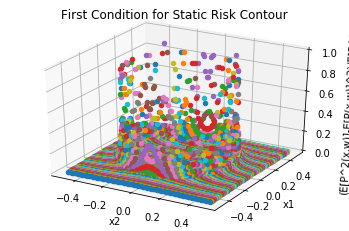

In [6]:
# Example: Risk contour plot for C0
x_1 = np.linspace(-.5,.5,100)
x_2 = np.linspace(-.5,.5,100)
x1 = Symbol('x1')
x2 = Symbol('x2')

fig = plt.figure()
ax = plt.axes(projection='3d')

# obstacle equation
g = random_ob()
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.3,.4)

for x in x_1:
    for y in x_2:
        C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
        ax.scatter3D(x, y, float(C_array[0]))
ax.set_zlim(0,1)
ax.set_title('First Condition for Static Risk Contour')
ax.set_zlabel('(E[P^2(x,w)]-E[P(x,w)]^2)/E[P^2(x,w)]')
ax.set_xlabel('x2')
ax.set_ylabel('x1')

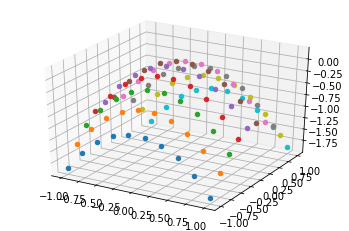

In [12]:
# Example: Risk contour plot for C1
x_1 = np.linspace(-1,1,10)
x_2 = np.linspace(-1,1,10)
x1 = Symbol('x1')
x2 = Symbol('x2')

fig = plt.figure()
ax = plt.axes(projection='3d')

# obstacle equation
g = random_ob()
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.3,.4)

for x in x_1:
    for y in x_2:
        C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
        ax.scatter3D(x, y, float(C_array[1]))
        
ax.set_title('Second Condition for Static Risk Contour')
ax.set_zlabel('E[P(x,w)]')
ax.set_xlabel('x2')
ax.set_ylabel('x1')

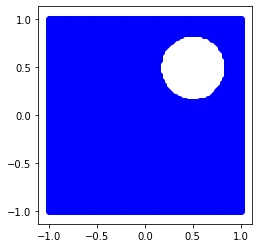

In [9]:
# Risk Contour Example: safe region with offset
x_1 = np.linspace(-1,1,100)
x_2 = np.linspace(-1,1,100)
x1 = Symbol('x1')
x2 = Symbol('x2')

# obstacle equation
g = random_ob(.5,.5)
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.3,.4)

fig, ax = plt.subplots()
for x in x_1:
    for y in x_2:
        C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
        # equation 10
        if (C_array[0] <= .5 and C_array[1] <= 0):
            plt.scatter(x,y,color='b')
ax.set_aspect('equal')

plt.title('Example Safe Region for 0.5 Acceptable Risk')
plt.xlabel('x1')
plt.ylabel('x2')

### Functions for creating safe region obstacles

Given a risk contour polynomial for an obstacle, the radius of that contour at the acceptable risk level (risk) is determined using the get_contour_radius function. The function searches the region surrounding the obstacle to find where the first condition of Equation 6 is equivalent to the acceptable risk value. The radius for each point in the region is found using Equation 9.

<font size="3"><h1><center>$\sqrt{(x-x_{c})^2+(y-y_{c})^2)}$<div style="text-align: right"> (9) </div><br></center></h1></font>
Where x and y are the coordinates for the points which satisfy the first risk contour condition in Equation 6 and $x_{c}$ and $y_{c}$ are the coordinates for the center point of the obstacle. The radius of the risk contour is determined by taking the mean of the recorded radii.

In [19]:
## Function definition
#
# input
#    C: polynomial that represents equation 6 
#    risk: acceptable risk for a given trajectory (contour risk delta)
#    center: (x,y) tuple of (known) center of expected object location
#
# output
#    float: estimated radius of given contour
#

def get_contour_radius(C, risk, center):
    # Risk Contour Example: safe region with offset
    xc = center[0]
    yc = center[1]
    x_1 = np.linspace(xc-1,xc+1,25)
    x_2 = np.linspace(yc-1,yc+1,25)
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    r_min = float(np.inf)   # large number
    for x in x_1:
        for y in x_2:
            C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
            # equation 6
            if C_array[1] <= 0 and C_array[0] <= risk and np.sqrt((x-xc)**2+(y-yc)**2) < r_min:
                r_min = np.sqrt((x-xc)**2+(y-yc)**2)
#                 plt.scatter(x,y,color='b')
    return r_min

g = random_ob()
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.3,.4)

print(get_contour_radius(C,0.5,(0,0)))


0.3726779962499648


Random obstacles for the environment are generated using the get_obstacles function. The following steps are competed to create the entire set of obstacles:

1. The number of obstacles in the environment and bounds for the environment are inputs to change the environment's generation process. random centers are first generated for the obstacles (centers). 

2. The random intervals of the uniform distributions over the obstacles' radii are computed (us and ls). 

3. Polynomials are generated for each obstacle (gs)

4. Risk contour polynomials are generated for each obstacle (C_list)

5. The radius and center for each risk contour are found and returned as two arrays by the function.

In [20]:
## Function definition
#
# input
#    num_obs: number of obstacles in the environment
#    risk: acceptable risk for a given trajectory (contour risk delta)
#    bounds: geographical bounds of environment
#
# output
#    centers: list of center locations of obstacles
#    radii: list of radius of risk contour of each obstacle
#
def get_obstacles(num_obs = 5, risk=0.5, bounds=np.array([[-1, 10], [-1, 10]])):
    random.seed(3)
    delta=risk # define acceptable risk
    span = bounds[:,1]-bounds[:,0] # define environment bounds
    border = 0.2 # obstacles should be fully contained in environment (allows us to place initial and final points)
    maxu = .5 # maximum obstacle upper bound
    minu = .2 # minimum obstacle upper bound
    
    # generate centers of obstacles
    xcs = [random.uniform(bounds[0,0]+border*span[0], bounds[0,1]-border*span[0]) for i in range(num_obs)]
    ycs = [random.uniform(bounds[1,0]+border*span[1], bounds[1,1]-border*span[1]) for i in range(num_obs)]
    centers = np.vstack((xcs,ycs))
    
    # generate upper and lower bound for obstacle diameters 
    us = np.array([random.uniform(minu, maxu) for i in range(num_obs)])
    ls = 0.8*us
    
    # create obstacles
    gs = [random_ob(xcs[i],ycs[i]) for i in range(num_obs)]
    
    # generate C equations for each obstacle
    C_list = [static_rc(gs[i],ls[i],us[i]) for i in range(num_obs)]
    radii = []
    centers = []
    
    # find the radius of each risk contour
    for i, C in enumerate(C_list):
        center = [xcs[i], ycs[i]]
        radius = get_contour_radius(C,delta,center)
        radii.append(radius)
        centers.append(center)
    return np.array(centers), np.array(radii), C_list

### Map Setting & Visualization

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd03a08bdd8>)

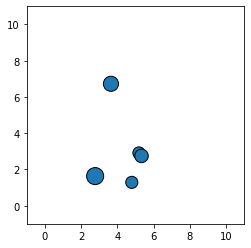

In [21]:
num_obs = 5
bounds = np.array([[-1, 10], [-1, 10]])
delta = 0.9
init = (0,0)
goal = (9,9)
centers, radii, C_list = get_obstacles(num_obs, delta, bounds) # TODO: make sure obstacles are not generated over init & goal

def draw_map(cetners, radii):
    fig, ax = plt.subplots()
    for i, center in enumerate(centers):
        obsArtist = plt.Circle(center, radius=radii[i], edgecolor='Black')
        ax.add_artist(obsArtist)

    ax.set_ylim([-1, 11])
    ax.set_xlim([-1, 11])
    ax.set_aspect('equal')
    
    return fig, ax

draw_map(centers, radii)

## 3. Generating an Initial Solution for Trajectory Optimization using RRT*

In this section, we implement a sampling-based planning method RRT which is asymptotically optimal unlike RRT, and we employ it to generate an initial solution for our trajectory optimization problem. With this goal, we first define a tree structure to organize the sampled points with its member functions to utilize in the implementation of RRT.

In [22]:
class Tree_Node:
    def __init__(self, coord_x, coord_y, parent=None, children=[], cost=0):
        self.coord_x = coord_x
        self.coord_y = coord_y
        self.parent = parent
        self.children = [] + children
        self.cost = 0
    
    # calculate Euclidian distance to the target node
    def distance(self, target):
        return np.sqrt((self.coord_x-target.coord_x)**2 + (self.coord_y-target.coord_y)**2)
    
    # find the nearest node from the target node in the subtree of the current node
    def Nearest(self, target):
        dist = self.distance(target)
        x_nearest = self
        if self.children == []:
            return dist, x_nearest
        for child in self.children:
            d_c, x_c = child.Nearest(target)
            if d_c < dist:
                dist = d_c
                x_nearest = x_c
        return dist, x_nearest
    
    # check whether the current node is arrived at the goal state
    def Arrive(self, goal):
        return self.coord_x == goal[0] and self.coord_y == goal[1]
    
    # find the neighborhood of the target node wihthin the radius in the subtree of the current node
    def Near(self, target, radius):
        X_near = []
        if self.distance(target) < radius:
            X_near.append(self)
        for child in self.children:
            X_near = X_near + child.Near(target, radius)
        return X_near

Besides the tree structure, RRT* (or RRT as well) requires two important functions, $Steer$ and $ObstacleFree$, that could be taylored to our problem. We first introduce the concept of a bit complex method introduced in the paper (https://arxiv.org/pdf/2106.05489.pdf) to enrich the context over what we have learned in the lecture. However, for simplicity, we implement more straightforward method in this notebook.

By letting the $Steer$ function to expand the tree with polynomial path represented as $x(t) = \sum_{i=0}^d c_i t^i \;\; t \in [t_1, t_2]$, we can generate a smooth piece-wise polynomial trajectory which is more realistic for robots than a piece-wise linear one. To check collisions for this polynomial path, an SOS-based continuous-time technique could be utilized. From part 2, we have formulated conditions for a point $x$ in a trajectory to be safe with the maximum risk of $\Delta$ to collide with uncertain static obstacles as $\frac{\mathbb{E}[P^2(x, \omega)] - \mathbb{E}[P(x, \omega)]^2}{\mathbb{E}[P^2(x, \omega)]} \leq \Delta \land \mathbb{E}[P(x, \omega)] \leq 0 $. With known momentums of $\omega$, the conditions are polynomial in $x$, and then the feasible set for the trajectory optimization problem can be presented as $\mathcal{S}=\{x: g_i(x) \geq 0 \;\; i=1,\dots,l\}$ for some polynomials $g_i$. Then, the safety of $x(t)$ could be checked by checking whether each polynomial $g_i(x(t))$ can be represented with SOS polynomials as $g_i(x(t)) = \sigma_{0i}(t) + \sigma_{1i}(t)(t-t_1) + \sigma_{2i}(t)(t_2-t)$ where $\sigma_{0i}(t), \sigma_{1i}(t), \sigma_{2i}(t)$ are SOS polynomials. This verification process can be implemented using Yalmip and Spotless packages.

In this notebook, for simplicity, we employ straightforawrd $Steer$ function that we have learned in the lecture and verify safety through an apporximate collision-checking method. Given a sampled point and the current state of the tree, $Steer$ finds the node in the tree nearest to the sampled point, and generates a linear path from that node towards the sampled point (not necessarily ending at the sampled point) with limited maximum length of the path. In $ObstacleFree$, we sample points along the linear path, and check for each point whether it resides in $\mathcal{S}$. By sampling densely enough, we can approximately check if the exented path is free from collision with obstacles.


In [23]:
## Function definition
#
# input
#    x_nearest: nearest point to x_rand in the tree
#    x_rand: sampled point towards which the tree needs to grow
#    max_dist: maximum distance of the extended path
#
# output
#    x_new: new point in the tree
#

def Steer(x_nearest, x_rand, max_dist=0.4):
    dist = x_nearest.distance(x_rand)
    x_new = x_rand
    if dist > max_dist:
        x_new.coord_x = x_nearest.coord_x + (max_dist/dist)*(x_rand.coord_x-x_nearest.coord_x)
        x_new.coord_y = x_nearest.coord_y + (max_dist/dist)*(x_rand.coord_y-x_nearest.coord_y)
    return x_new

In [24]:
## Function definition
#
# input
#    x_nearest: the point closest to x_new
#    x_new: randomly chosen point by RRT
#    C_list: list of polynomials for each obstacle that represent equation 10 
#    delta: acceptable risk level, [0,1]
#    num_points: number of points to sample along the path
#
# output
#    boolean: True if the temporary trajectory that steer() function generates hits obstacles, otherwise False.
#

def ObstacleFree(x_nearest, x_new, C_list, delta, num_points=10):
    for i in range(1, num_points + 1):
        x = x_nearest.coord_x + (i/num_points)*(x_new.coord_x-x_nearest.coord_x)
        y = x_nearest.coord_y + (i/num_points)*(x_new.coord_y-x_nearest.coord_y)
        for C in C_list:
            if not check_safe(delta, C, x, y):
                return False
    return True

Additionally, RRT* (or RRT as well) needs a function to sample a random point to expand a path toward. We implement this function with goal-biasing to encourage goal-reaching paths.

In [25]:
# sample a random point x_rand with goal-biasing in the area defined with bounds
def SampleFree(i, goal, bounds):
    # goal-biasing
    if i%20 == 0:
        x_rand = Tree_Node(goal[0], goal[1]) 
    else:
        ran = np.random.random_sample((2,))
        x_rand = Tree_Node((bounds[0][1]-bounds[0][0])*ran[0]+bounds[0][0], (bounds[1][1]-bounds[1][0])*ran[1]+bounds[1][0])
    return x_rand

Then, using the functions defined above, we can employ RRT* to generate a trajectory with bounded risk $\Delta$ to collide with uncertain static obstacles.

In [27]:
## Function definition
#
# input
#    init: initial sate of the robot
#    goal: goal state of the robot
#    C_list: list of polynomials for each obstacle that represent equation 10 
#    delta: acceptable risk level, [0,1]
#
# output
#    trajectory: list of successvie paths represented with parameters
#    cost: cost (distance) of the generated trajectory
#

def generate_trajectory(init, goal, C_list, delta):
    root = Tree_Node(init[0], init[1])
    N = 100000
    tree_node_num = 1
    gamma = 0.8
    d = 2
    eta = 0.5
    trajectory = []
    for i in range(N):
        x_rand = SampleFree(i, goal, bounds)
        
        dist, x_nearest = root.Nearest(x_rand)
        if dist <= 1e-5:
            continue
        
        x_new = Steer(x_nearest, x_rand)
        
        if ObstacleFree(x_nearest, x_new, C_list, delta):
            X_near = root.Near(x_new, min(gamma*(log(tree_node_num)/tree_node_num)**(1/d), eta))
            
            x_min = x_nearest
            c_min = x_nearest.cost + x_nearest.distance(x_new)
            
            # Connect along a minimum-cost (minimum-distance) path
            for x_near in X_near:
                if ObstacleFree(x_near, x_new, C_list, delta) and x_near.cost + x_near.distance(x_new) < c_min:
                    x_min = x_near
                    c_min = x_near.cost + x_near.distance(x_new)
            
            x_new.parent = x_min
            x_new.cost = c_min
            x_min.children.append(x_new)
            tree_node_num += 1
            
            # Rewire the tree
            for x_near in X_near:
                if ObstacleFree(x_new, x_near, C_list, delta) and x_new.cost + x_new.distance(x_near) < x_near.cost:
                    x_near.parent.children.remove(x_near)
                    x_near.parent = x_new
                    x_near.cost = x_new.cost + x_new.distance(x_near)
                    x_new.children.append(x_near)
                
            if x_new.Arrive(goal):
                trajectory = [(x_new.coord_x, x_new.coord_y)]
                node = x_new
                while node.parent != None:
                    parent = node.parent
                    trajectory.insert(0, (parent.coord_x, parent.coord_y))
                    node = parent
                break
    return trajectory, x_new.cost

For RRT*, there is a trade-off between the quality of the generated path and the computation time. We can control it by setting a range to search neighborhood differently since larger range induces more extensive correction of the tree structure when a new node is added. The range is determined by calculating $\min\{\gamma (\frac{\log(|V|)}{|V|})^{1/d}, \eta\}$ where $|V|$ is the number of nodes in the tree. In the first term, $d$ characterizes how the range decays as the tree grows and $\gamma$ changes overall scale. The below cell is useful to test and determine the constants.

Text(0, 0.5, 'Range')

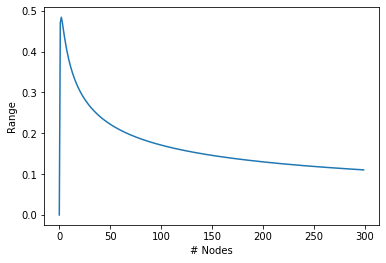

In [7]:
# Test for choosing hyperparameters in calculating radius for neighborhood search
length = 300
f = np.zeros(length)
gamma = .8
d = 2
for i in range(length):
    f[i] = gamma*(log(i+1)/(i+1))**(1/d)
plt.plot(f)
plt.xlabel("# Nodes")
plt.ylabel("Range")
plt.title('Testing RRT* Hyperparameters')

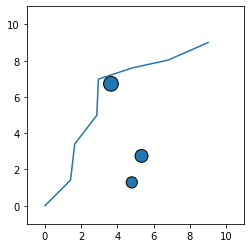

In [41]:
# Generate initial solution using RRT*
# CAUTION!! It may take ~30 minutes to execute the code

trajectory, total_cost = generate_trajectory(init, goal, C_list, delta)

fig, ax = draw_map(centers, radii)

x_coords = []
y_coords = []
for waypoint in trajectory:
    x_coords.append(waypoint[0])
    y_coords.append(waypoint[1])
plt.plot(x_coords, y_coords)
plt.title('RRT* Path Generation')
plt.xlabel('x1')
plt.ylabel('x2')

## Functions for Optimization

As mentioned previously, we will be using the scipy library function *minimize* to solve the problem given by Eq. 2 in Section 1. The use of this function requires the use of two support functions, namely a cost function *cost(xN)* which determines the cost of a given trajectory, and *nonlcon(xN, params)* which checks that the trajectory satisfies the constraints of the problem. The function stubs for these two functions, as well as the main optimization function are summarized below:

In [28]:
# Parameters for the current optimization problem.
class Parameters:
    def __init__(self, num_obstacles=8, env_bounds=np.array([[-1,10],[-1,10]])):
        self.deg = 7    # Degree of Bernstein polynomials being used
        self.tf = 20.0  # Final time estimate (will be )
        self.dsafe = 0.5  # Minimum safe distance between vehicle and obstacles
        self.vmax = 0.1  # Maximum speed
        self.wmax = 2*3*np.pi/2 # Maximum angular rate
        self.riskmax = 0.1 # Maximum allowable risk
        self.degree_elevation = 5

        self.pos0 = np.array([0,0],dtype=float) # Initial position
        self.posf = np.array([10,10],dtype=float) # Final points
        
        centers, radii, C_list = get_obstacles(num_obstacles, self.riskmax, env_bounds)
        self.obstacles = centers # obstacle positions
        self.safe_dists = radii # risk contour radius for each obstacle
        
        # RRT Params



In [29]:
## Function definition
#
# input
#    vector: vectorized set of control points being optimized + tf for current trajectory
#
# output
#    xN: matrix of control points for Bernstein polynomial
#    tf: time to execute the trajectory given by the bernstein polynomial described by xN
#
def reform(vector,params):
    N = int((len(vector)-1)/2)
    pos0 = params.pos0
    posf = params.posf
    x = np.concatenate(([pos0[0]], vector[0:N], [posf[0]]))
    y = np.concatenate(([pos0[1]], vector[N:-1], [posf[1]]))
    # pdb.set_trace()
    xN = np.vstack((x, y))
    tf = vector[-1]
    # pdb.set_trace()
    return xN, tf

In [30]:
## Function definition
#
# input
#    opt_vec: vectorized set of control points being optimized + tf for current trajectory
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max velocity, max angular velocity
#
# output
#    cost: the cost value of the control points given by the input
#

def cost(opt_vec,params): 
    xN, tf = reform(opt_vec,params)
    dist_sum = 0.0
    num_points = xN.shape[1]
    
    
    for i in range(num_points-1):
        dist = np.sqrt((xN[0][i]-xN[0][i+1])**2+(xN[1][i]-xN[1][i+1])**2)
        dist_sum += dist
    return dist_sum

In [31]:
## Function definition
#
# input
#    opt_vec: vectorized set of control points being optimized + tf for current trajectory
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max velocity, max angular velocity
#
# output
#    constraints: a vector of the constrained variables associated with the problem. Must be >=0 to be satisfied
#

def nonlcon(opt_vec, params): 
    # reform the optimization vector into an easy form to work with and unload problem parameters
    xN, tf = reform(opt_vec, params)
    degree_elevation = params.degree_elevation
    obstacles = params.obstacles
    safe_dists = params.safe_dists

    
    
    # generate bernstein polynomials from matrix of control points
    bp = Bernstein(xN, tf=tf)
    
    # find speed control points and use degree elevation to reduce conservativism
    speedN = bp.diff().normSquare().elev(degree_elevation).cpts.flatten() # Bernstein polynomial representing speed

    bpdot = bp.diff()
    bpddot = bpdot.diff()

    xdot = bpdot.x
    ydot = bpdot.y
    xddot = bpddot.x
    yddot = bpddot.y

    num = yddot*xdot - xddot*ydot
    den = xdot*xdot + ydot*ydot
    
    # find angular rate control points and use degree elevation to reduce conservativism
    wN = num.elev(degree_elevation).cpts / den.elev(degree_elevation).cpts
    wN = wN.flatten() # Rational bernstein polynomial representing angular rate
    
    # Obstacles:
    dist_bps = []
    dist_constraint = []
    for i, obs in enumerate(obstacles):
        obsN = np.ones((2, params.deg+1), dtype=float)
        obsN[0] *= obs[0]
        obsN[1] *= obs[1]
        # describe obstacles as constant bernstein polynomials
        obsbp = Bernstein(obsN,tf=tf)
        distbp = bp-obsbp
        dist_constraint.append(distbp.normSquare().elev(degree_elevation).cpts-safe_dists[i]**2) # control points 
                                                                                                 # representing dist-
                                                                                                 # ance to obstacle
        
    distN = np.array(dist_constraint).flatten() 
    
    # constraints: vector of points representing speed constraint, angular rate constraint, and distance to obstacles
    constraints = np.concatenate((params.vmax**2-speedN, params.wmax**2-wN, distN))
    
    return constraints

In [32]:
## Function definition
#
# input
#    x0: initial guess of control points created by generate_trajectory
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max and min velocity, max and min angular velocity
#
# output
#    xN_opt: set of control points representing the Bernstein polynomial approximation to the optimal trajectory
#

def generate_optimal_trajectory(x0, params): 
    # Use minimize function to generate an approximation to the optimal trajectory:
    # xN_opt = minimize(@(x)cost(x),x0,@(x)nonlcon(x,params))

    
    def fn(x): return cost(x, params)
    cons = [{'type': 'ineq',
             'fun': lambda x: nonlcon(x, params)}]
    bounds = Bounds(-1000, 1000)

    results = minimize(fn, x0,
                       constraints=cons,
                       bounds=bounds,
                       method='SLSQP',
                       options={'maxiter': 250,
                                'disp': True,
                                'iprint': 2})
    xN_opt, tf = reform(results.x, params)
    return xN_opt, tf

  NIT    FC           OBJFUN            GNORM
    1    15     1.414214E+01     0.000000E+00
    2    31     1.759451E+01     2.495441E+00
    3    46     3.960245E+01     4.510753E+00
    4    61     4.748891E+01     4.712263E+00
    5    76     4.489692E+01     4.739689E+00
    6    91     4.046190E+01     4.466182E+00
    7   106     2.674796E+01     4.071315E+00
    8   121     2.664318E+01     4.200145E+00
    9   136     3.432810E+01     4.248963E+00
   10   152     3.504199E+01     4.240642E+00
   11   167     3.494163E+01     4.226255E+00
   12   182     3.293163E+01     4.203480E+00
   13   197     3.108334E+01     4.271028E+00
   14   212     3.061148E+01     4.271207E+00
   15   227     2.928978E+01     4.262786E+00
   16   242     2.401297E+01     3.823206E+00
   17   257     2.168963E+01     3.663268E+00
   18   272     2.060157E+01     2.883071E+00
   19   287     2.003015E+01     2.964631E+00
   20   303     1.990161E+01     2.828771E+00
   21   320     1.989268E+01     2

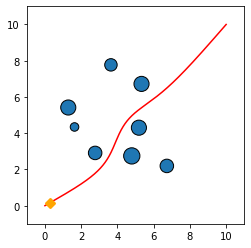

In [34]:
num_obstacles = 8
env_bounds = np.array([[-1,10],[-1,10]])

params = Parameters(num_obstacles, env_bounds)

x0 = np.concatenate((np.linspace(1,9,params.deg-1), np.linspace(1,9,params.deg-1), [params.tf]))


xN_opt, tf = generate_optimal_trajectory(x0,params)
bp = Bernstein(xN_opt,tf=tf)

print("tf: {} s".format(tf))

plt.close('all')
fig, ax = plt.subplots()

bp.plot(ax, showCpts=False,color='r')
pt10 = bp(5)
plt.plot(pt10[0], pt10[1], 'x', markeredgewidth=7, zorder=10, color='orange')

# for obs in params.obstacles:
#         obsArtist = plt.Circle(obs, radius=params.dsafe, edgecolor='Black')
#         ax.add_artist(obsArtist)

for i, obs in enumerate(params.obstacles):
        obsArtist = plt.Circle(obs, radius=params.safe_dists[i], edgecolor='Black')
        ax.add_artist(obsArtist)

ax.set_ylim([-1, 11])
ax.set_xlim([-1, 11])
ax.set_aspect('equal')